In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, transpile
from qiskit.circuit import Gate, Parameter

from rttgen import PulseEfficientCR, CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step_no_opt, single_step, two_steps
from trotter import trotter_step_circuits
from observables import combined_counts, plot_counts_with_curve

In [2]:
nsites = 2

aJ = 1. # Hamiltonian J parameter
am = 0.5 # Hamiltonian mu parameter

M = 8 # number of Trotter steps
omegadt = 0.2 # Trotter step size

In [3]:
backend = Aer.get_backend('qasm_simulator')
physical_qubits = None

In [4]:
rtts_cnot = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in [(0, 1), (1, 2), (2, 3)])
cxs = {(0, 1): cx_circuit(backend, 0, 1), (1, 0): cx_circuit(backend, 1, 0)}

## Define and submit all circuits

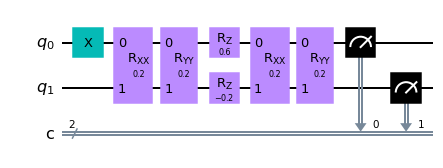

In [6]:
single_step_circuit = single_step_no_opt(nsites, aJ, am, omegadt)
circuits = trotter_step_circuits(M, single_step_circuit)
circuits = transpile(circuits, backend=backend, optimization_level=3)

job_naive = backend.run(circuits, shots=10000)
circuits[1].draw('mpl', idle_wires=False)

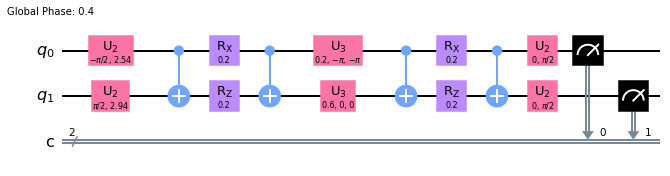

In [7]:
single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts_cnot, cxs=cxs)
two_step_circuit = two_steps(nsites, aJ, am, omegadt, rtts=rtts_cnot, cxs=cxs)
circuits = trotter_step_circuits(M, single_step_circuit, two_step_circuit)
circuits = transpile(circuits, backend=backend)

job_cnot = backend.run(circuits, shots=10000)
circuits[1].draw('mpl', idle_wires=False)

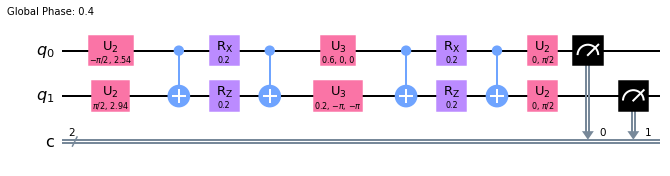

In [8]:
single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts_cnot, cxs=cxs)
circuits = trotter_step_circuits(M, single_step_circuit)
circuits = transpile(circuits, backend=backend)

job_cnot_single = backend.run(circuits, shots=10000)
circuits[1].draw('mpl', idle_wires=False)

## Naive circuit (optimization level 3)

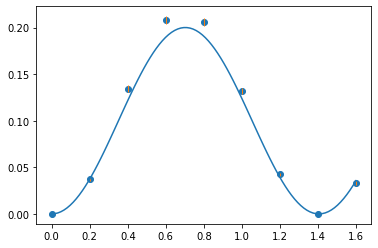

In [9]:
plot_counts_with_curve(combined_counts(job_naive, M), nsites, aJ, am, omegadt, M)

## Optimized circuit with CNOT-based Rtt

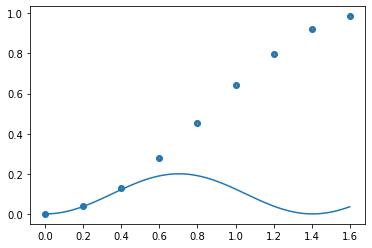

In [10]:
plot_counts_with_curve(combined_counts(job_cnot, M), nsites, aJ, am, omegadt, M)

## Optimized circuit with CNOT-based Rtt, all single steps

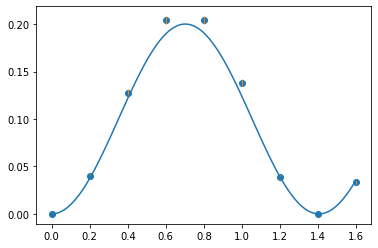

In [11]:
plot_counts_with_curve(combined_counts(job_cnot_single, M), nsites, aJ, am, omegadt, M)